In [1]:
import os

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRegressor

import shap
import altair as alt
import matplotlib.pyplot as plt
alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")
alt.data_transformers.enable("data_server")

DataTransformerRegistry.enable('data_server')

In [2]:
df = pd.read_csv("../data/processed/clean_data.csv").dropna()
df.shape
df.head()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

X_train, y_train = train_df.drop(columns=["bloom_doy"]), train_df["bloom_doy"]
X_test, y_test = test_df.drop(columns=["bloom_doy"]), test_df["bloom_doy"]

In [3]:
categorical_features = ["country", "city"]
numeric_features = [
    "lat",
    "long",
    "alt",
    "tmax",
    "tmin",
    "prcp",
    "agdd_winter",
    "tmax_winter",
    "prcp_winter",
    "co2_percapita",
    "co2_emission",
]
drop_features = ["year"]
target = "bloom_doy"

In [4]:
scaler = StandardScaler()
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # scaling on numeric features
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_features,
    ),  # OHE on categorical features
    ("drop", drop_features),  # drop features
)

preprocessor.fit_transform(X_train).shape

(4327, 120)

In [5]:
results = {}  # dictionary to store all the results

In [6]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [7]:
# make a scorer function that we can pass into cross-validation


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


mape_scorer = make_scorer(mape, greater_is_better=False)

In [8]:
scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [9]:
# making pipelines for all the regressor models and storing in "models" dictionary
models = {
    "Baseline": make_pipeline(preprocessor, DummyRegressor()),
    "Ridge": make_pipeline(preprocessor, Ridge(random_state=123)),
    "Lasso": make_pipeline(preprocessor, Lasso(random_state=123)),
    "Decision Tree": make_pipeline(
        preprocessor, DecisionTreeRegressor(random_state=123)
    ),
    "CatBoost": make_pipeline(
        preprocessor, CatBoostRegressor(verbose=0, random_state=123)
    ),
    "XGBoost": make_pipeline(preprocessor, XGBRegressor(verbosity=0, random_state=123)),
    "LGBM": make_pipeline(preprocessor, LGBMRegressor(random_state=123)),
}

# saving the mean cross validation scores in resutls dictionary created previously
for model_name, model in models.items():
    results[model_name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [10]:
pd.DataFrame(results)

,Baseline,Ridge,Lasso,Decision Tree,CatBoost,XGBoost,LGBM
fit_time,0.008 (+/- 0.002),0.011 (+/- 0.001),0.037 (+/- 0.001),0.081 (+/- 0.001),1.535 (+/- 0.078),0.194 (+/- 0.004),0.105 (+/- 0.015)
score_time,0.004 (+/- 0.000),0.005 (+/- 0.001),0.005 (+/- 0.000),0.005 (+/- 0.000),0.008 (+/- 0.001),0.013 (+/- 0.000),0.009 (+/- 0.001)
test_neg RMSE,-21.795 (+/- 1.233),-5.781 (+/- 0.225),-9.869 (+/- 0.400),-6.500 (+/- 0.323),-4.252 (+/- 0.075),-4.356 (+/- 0.106),-4.271 (+/- 0.101)
train_neg RMSE,-21.806 (+/- 0.312),-5.552 (+/- 0.042),-9.820 (+/- 0.068),0.000 (+/- 0.000),-2.592 (+/- 0.027),-1.531 (+/- 0.066),-2.784 (+/- 0.027)
test_r2,-0.003 (+/- 0.002),0.929 (+/- 0.009),0.794 (+/- 0.008),0.910 (+/- 0.010),0.962 (+/- 0.004),0.960 (+/- 0.004),0.961 (+/- 0.004)
train_r2,0.000 (+/- 0.000),0.935 (+/- 0.002),0.797 (+/- 0.003),1.000 (+/- 0.000),0.986 (+/- 0.000),0.995 (+/- 0.000),0.984 (+/- 0.001)
test_mape,-21.041 (+/- 2.937),-5.116 (+/- 0.418),-9.745 (+/- 1.072),-5.193 (+/- 0.596),-3.635 (+/- 0.340),-3.593 (+/- 0.359),-3.600 (+/- 0.354)
train_mape,-21.031 (+/- 0.605),-4.934 (+/- 0.093),-9.696 (+/- 0.216),0.000 (+/- 0.000),-2.328 (+/- 0.047),-1.263 (+/- 0.037),-2.421 (+/- 0.058)


## Feature Selection 

In [11]:
# creating a pipeline model with preprocessor, L1 regularization and LGBMRegressor
pipe_l1_lgbm = make_pipeline(
    preprocessor,
    SelectFromModel(Lasso(alpha=0.01, max_iter=100000)),
    LGBMRegressor(random_state=123),
)

In [12]:
# finding mean cross validation scores for the model and storing the resutls in the "results" dictionary
results["LGBM + L1 regularization"] = mean_std_cross_val_scores(
    pipe_l1_lgbm, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

In [13]:
# displaying the scores of all the models so far created
pd.DataFrame(results)

,Baseline,Ridge,Lasso,Decision Tree,CatBoost,XGBoost,LGBM,LGBM + L1 regularization
fit_time,0.008 (+/- 0.002),0.011 (+/- 0.001),0.037 (+/- 0.001),0.081 (+/- 0.001),1.535 (+/- 0.078),0.194 (+/- 0.004),0.105 (+/- 0.015),0.333 (+/- 0.042)
score_time,0.004 (+/- 0.000),0.005 (+/- 0.001),0.005 (+/- 0.000),0.005 (+/- 0.000),0.008 (+/- 0.001),0.013 (+/- 0.000),0.009 (+/- 0.001),0.007 (+/- 0.001)
test_neg RMSE,-21.795 (+/- 1.233),-5.781 (+/- 0.225),-9.869 (+/- 0.400),-6.500 (+/- 0.323),-4.252 (+/- 0.075),-4.356 (+/- 0.106),-4.271 (+/- 0.101),-4.299 (+/- 0.092)
train_neg RMSE,-21.806 (+/- 0.312),-5.552 (+/- 0.042),-9.820 (+/- 0.068),0.000 (+/- 0.000),-2.592 (+/- 0.027),-1.531 (+/- 0.066),-2.784 (+/- 0.027),-2.771 (+/- 0.032)
test_r2,-0.003 (+/- 0.002),0.929 (+/- 0.009),0.794 (+/- 0.008),0.910 (+/- 0.010),0.962 (+/- 0.004),0.960 (+/- 0.004),0.961 (+/- 0.004),0.961 (+/- 0.004)
train_r2,0.000 (+/- 0.000),0.935 (+/- 0.002),0.797 (+/- 0.003),1.000 (+/- 0.000),0.986 (+/- 0.000),0.995 (+/- 0.000),0.984 (+/- 0.001),0.984 (+/- 0.000)
test_mape,-21.041 (+/- 2.937),-5.116 (+/- 0.418),-9.745 (+/- 1.072),-5.193 (+/- 0.596),-3.635 (+/- 0.340),-3.593 (+/- 0.359),-3.600 (+/- 0.354),-3.619 (+/- 0.365)
train_mape,-21.031 (+/- 0.605),-4.934 (+/- 0.093),-9.696 (+/- 0.216),0.000 (+/- 0.000),-2.328 (+/- 0.047),-1.263 (+/- 0.037),-2.421 (+/- 0.058),-2.417 (+/- 0.058)


## Distance Based Models

In [14]:
models_distance = {
    "Support Vector": make_pipeline(preprocessor, SVR(epsilon=0.2)),
    "KNN": make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors=30, weights="uniform", algorithm="auto"),
    ),
}

# saving the mean cross validation scores in resutls dictionary created previously
for model_name, model in models_distance.items():
    results[model_name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [15]:
# displaying the scores of all the models so far created
pd.DataFrame(results)

,Baseline,Ridge,Lasso,Decision Tree,CatBoost,XGBoost,LGBM,LGBM + L1 regularization,Support Vector,KNN
fit_time,0.008 (+/- 0.002),0.011 (+/- 0.001),0.037 (+/- 0.001),0.081 (+/- 0.001),1.535 (+/- 0.078),0.194 (+/- 0.004),0.105 (+/- 0.015),0.333 (+/- 0.042),0.351 (+/- 0.011),0.008 (+/- 0.001)
score_time,0.004 (+/- 0.000),0.005 (+/- 0.001),0.005 (+/- 0.000),0.005 (+/- 0.000),0.008 (+/- 0.001),0.013 (+/- 0.000),0.009 (+/- 0.001),0.007 (+/- 0.001),0.063 (+/- 0.001),0.108 (+/- 0.002)
test_neg RMSE,-21.795 (+/- 1.233),-5.781 (+/- 0.225),-9.869 (+/- 0.400),-6.500 (+/- 0.323),-4.252 (+/- 0.075),-4.356 (+/- 0.106),-4.271 (+/- 0.101),-4.299 (+/- 0.092),-9.266 (+/- 0.850),-6.888 (+/- 0.287)
train_neg RMSE,-21.806 (+/- 0.312),-5.552 (+/- 0.042),-9.820 (+/- 0.068),0.000 (+/- 0.000),-2.592 (+/- 0.027),-1.531 (+/- 0.066),-2.784 (+/- 0.027),-2.771 (+/- 0.032),-9.095 (+/- 0.098),-6.639 (+/- 0.113)
test_r2,-0.003 (+/- 0.002),0.929 (+/- 0.009),0.794 (+/- 0.008),0.910 (+/- 0.010),0.962 (+/- 0.004),0.960 (+/- 0.004),0.961 (+/- 0.004),0.961 (+/- 0.004),0.819 (+/- 0.013),0.899 (+/- 0.011)
train_r2,0.000 (+/- 0.000),0.935 (+/- 0.002),0.797 (+/- 0.003),1.000 (+/- 0.000),0.986 (+/- 0.000),0.995 (+/- 0.000),0.984 (+/- 0.001),0.984 (+/- 0.000),0.826 (+/- 0.004),0.907 (+/- 0.004)
test_mape,-21.041 (+/- 2.937),-5.116 (+/- 0.418),-9.745 (+/- 1.072),-5.193 (+/- 0.596),-3.635 (+/- 0.340),-3.593 (+/- 0.359),-3.600 (+/- 0.354),-3.619 (+/- 0.365),-8.964 (+/- 1.469),-5.962 (+/- 0.649)
train_mape,-21.031 (+/- 0.605),-4.934 (+/- 0.093),-9.696 (+/- 0.216),0.000 (+/- 0.000),-2.328 (+/- 0.047),-1.263 (+/- 0.037),-2.421 (+/- 0.058),-2.417 (+/- 0.058),-8.716 (+/- 0.247),-5.735 (+/- 0.162)


## Hyperparameter Optimization

In [16]:
cb_params = {
    "catboostregressor__max_depth": np.linspace(1, 32, 32, endpoint=True),
    "catboostregressor__n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
}

cb_rand = RandomizedSearchCV(
    models["CatBoost"],
    cb_params,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)
cb_random_search = cb_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\catboost\core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\alexx\miniconda3\env

In [17]:
print("Best hyper-params for cat boost:\n", cb_random_search.best_params_)

Best hyper-params for cat boost:
 {'catboostregressor__n_estimators': 200, 'catboostregressor__max_depth': 10.0}


In [18]:
pd.DataFrame(cb_random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_catboostregressor__max_depth",
        "param_catboostregressor__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

,mean_train_score,mean_test_score,param_catboostregressor__max_depth,param_catboostregressor__n_estimators,mean_fit_time
rank_test_score,,,,,
1,0.992650,0.960479,10.0,200,54.289737
2,0.978301,0.956007,6.0,100,8.359482
3,0.994726,0.953414,13.0,64,62.975222
4,0.970854,0.952661,5.0,64,4.138605
5,0.969197,0.940922,13.0,16,19.729971
6,0.898389,0.894939,3.0,4,0.413203
7,0.847495,0.837103,12.0,2,4.217227
8,0.841538,0.826377,16.0,2,12.501182
9,NaN,NaN,18.0,8,0.066804


In [19]:
# LightGBM
lgbm_params = {
    "lgbmregressor__max_depth": [i for i in range(1, 33)],
    "lgbmregressor__n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
}

lgbm_rand = RandomizedSearchCV(
    models["LGBM"],
    lgbm_params,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)
lgbm_random_search = lgbm_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [20]:
print('Best hyper-params for Light GBM:\n', lgbm_random_search.best_params_)


Best hyper-params for Light GBM:
 {'lgbmregressor__n_estimators': 200, 'lgbmregressor__max_depth': 17}


In [21]:
pd.DataFrame(lgbm_random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmregressor__max_depth",
        "param_lgbmregressor__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

,mean_train_score,mean_test_score,param_lgbmregressor__max_depth,param_lgbmregressor__n_estimators,mean_fit_time
rank_test_score,,,,,
1,0.991112,0.963196,17,200,0.448628
2,0.991160,0.963191,24,200,0.437731
3,0.991166,0.963180,30,200,0.397005
3,0.991166,0.963180,28,200,0.376398
5,0.989331,0.962382,10,200,0.346762
6,0.977537,0.958226,31,64,0.263106
7,0.977362,0.958048,13,64,0.158997
8,0.977165,0.957684,6,100,0.148401
9,0.967087,0.951847,5,64,0.113717


## Feature Importance

In [22]:
# Fit the preprocessor first
preprocessor.fit(X_train, y_train)

# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Create encoded train data
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

# Create encoded test data
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

# Fit regressor model using LGBMRegressor
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['lat', 'long', 'alt', 'tmax',
                                                   'tmin', 'prcp',
                                                   'agdd_winter', 'tmax_winter',
                                                   'prcp_winter',
                                                   'co2_percapita',
                                                   'co2_emission']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'city']),
                                                 ('drop', 'drop', ['year'])])),
                ('lgbmregressor', LGBMRegressor(random_state=123))])

In [28]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
# We are only extracting shapely values for the first 100 test examples for speed.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])
shap.initjs()

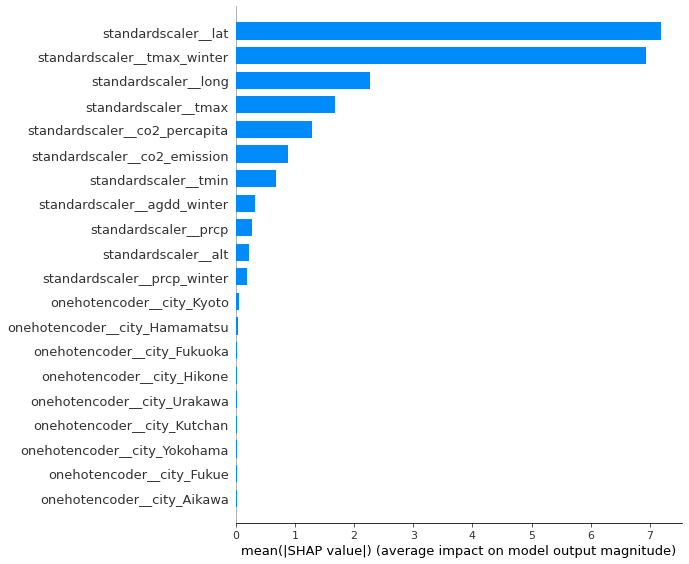

In [25]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

In [26]:
# Get all feature names
feature_names = preprocessor.get_feature_names_out()


In [27]:
# Create encoded train data
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,standardscaler__lat,standardscaler__long,standardscaler__alt,standardscaler__tmax,standardscaler__tmin,standardscaler__prcp,standardscaler__agdd_winter,standardscaler__tmax_winter,standardscaler__prcp_winter,standardscaler__co2_percapita,...,onehotencoder__city_Wajima,onehotencoder__city_Wakayama,onehotencoder__city_Wakkanai,onehotencoder__city_Washingtondc,onehotencoder__city_Yakushima,onehotencoder__city_Yokohama,onehotencoder__city_Yonago,onehotencoder__city_Yonagunijima,onehotencoder__city_Zürich-MeteoSchweiz,onehotencoder__city_Zürich-Witikon
543,-0.878378,0.061299,-0.345027,0.570050,0.717227,-0.093235,1.617665,0.783907,-0.273762,0.102825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1837,-0.459201,0.249723,0.170610,0.324767,-0.101294,-0.378672,0.038489,0.057680,-0.803767,0.257232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1334,-0.556700,0.231862,-0.417853,0.738906,0.694866,-0.680713,1.414153,0.803665,-0.660690,-0.048934,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5280,1.495794,0.477202,-0.263878,-2.037860,-1.734224,0.031133,-1.199722,-2.039002,0.371337,0.827305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3921,0.288934,0.386149,-0.255620,-0.322777,-0.272708,-0.504655,-0.247457,-0.269872,-0.613561,-1.997094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
